In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
import warnings
warnings.filterwarnings('ignore')
seed = 42

loan = pd.read_pickle("input.pickle")
X = loan.drop('loanStatus', axis=1)
y = loan['loanStatus']

### Resampling

In [2]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [3]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
# X_resampled, y_resampled = ADASYN().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(sorted(Counter(y_resampled).items()))

[(0.0, 12135), (1.0, 12135)]


## Preprocessing

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [5]:
numeric_transformer = Pipeline(
    steps=[('scaler', MinMaxScaler())
          ])

# categorical_transformer = Pipeline(
#     steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
# )

In [6]:
numeric_features = loan.select_dtypes(include=['int64', 'float64', 'uint8']).columns
categorical_features = loan.select_dtypes(include=['object', 'category']).columns

In [7]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
    ])

## Model Training

In [8]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, cross_validate

dt = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
base_estim = DecisionTreeClassifier()
ab = AdaBoostClassifier(random_state=seed)
gbm = GradientBoostingClassifier(random_state=seed)
xgb = XGBClassifier(random_state=seed)
lgbm = LGBMClassifier(random_state=seed)
cb = CatBoostClassifier(random_state=seed)
hgbm = HistGradientBoostingClassifier(random_state=seed)

In [ ]:
models = [dt, rf, ab, gbm, hgbm, xgb, lgbm, cb]
model_names = [i.__class__.__name__ for i in models]
es_models = ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

df_results = pd.DataFrame(columns=['accuracy', 'std', 'precision', 'recall', 'roc_auc', 'runtime'])
for m, n in zip(models, model_names):
    
    start_time = time()
    kfold = KFold(n_splits=10, random_state=seed)
#     results = cross_val_score(m, X_train, y_train, cv=kfold)
    results = cross_validate(m, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
    
    run_time = time() - start_time
        
    df_results.loc[n] = [results['test_accuracy'].mean(), results['test_accuracy'].std(), 
                         results['test_precision'].mean(), results['test_recall'].mean(),
                         results['test_roc_auc'].mean(), run_time]
    
    del m
    
df_results.to_pickle('results.pickle')    

In [10]:
df_results.sort_values(by='accuracy', ascending=False)

,accuracy,std,precision,recall,roc_auc,runtime
XGBClassifier,0.990420,0.002113,0.987812,0.993100,0.999348,132.036143
LGBMClassifier,0.990060,0.001677,0.987093,0.993086,0.999285,70.534277
HistGradientBoostingClassifier,0.989854,0.001152,0.987296,0.992459,0.999281,323.293178
CatBoostClassifier,0.989390,0.001327,0.987288,0.991534,0.999199,230.679123
RandomForestClassifier,0.986300,0.002074,0.985389,0.987171,0.998985,41.183008
GradientBoostingClassifier,0.979399,0.002467,0.979195,0.979572,0.997889,99.883135
AdaBoostClassifier,0.975382,0.003923,0.981462,0.968933,0.996675,23.163872
DecisionTreeClassifier,0.971982,0.003492,0.976314,0.967376,0.971945,7.725065


### Model Evaluation

In [11]:
from sklearn import metrics

In [12]:
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred_class = model.predict(X_test)
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}")
print(f"Recall: {metrics.recall_score(y_test, y_pred_class)}")

Accuracy: 0.9917593737124022
Recall: 0.9926289926289926


In [13]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[2390   22]
 [  18 2424]]


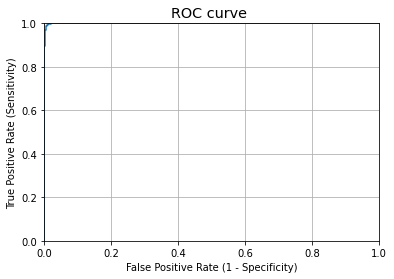

In [14]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve ')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Decision Tree Feature Importance

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
rankers = [DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

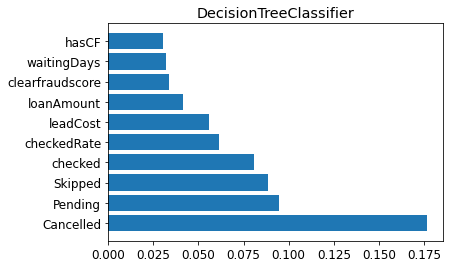

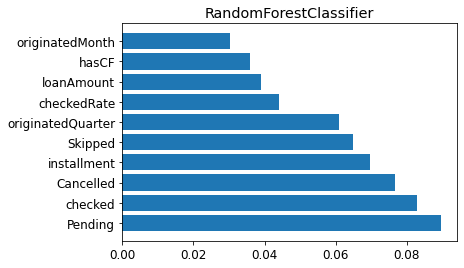

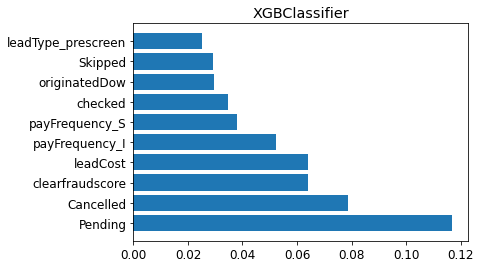

In [17]:
for m in rankers:
    model = m
    model.fit(X, y)
    importance = model.feature_importances_

    ranked = list(enumerate(importance))
    ranked = sorted(ranked, key=lambda x:x[1], reverse=True)
    ranked = list(zip(*ranked[:10]))

    plt.title(m.__class__.__name__)
    plt.barh([loan.columns[i] for i in ranked[0]], ranked[1])
    plt.show()

Features ranked important includes `Pending`, `installment`, `checked`.